# 0. Preprocessing

First we import the explore dataframe.

For the convenience purpose i will just put all the collecting data process in the backup block at the end.

So in order to reproduce it, you will need to go done to start with the data collection.

In [33]:
import pandas as pd
df_explore_venue=pd.read_csv("df_explore_venue.csv",index_col=0)
df_explore_venue

,nb_code,lat,lng,Venue,Venue_ID,Venue Latitude,Venue Longitude,Venue Category
0,11226,40.64643,-73.956866,Kings Theatre,4ea704af6d86f2edb667d8b7,40.646110,-73.957175,Theater
1,11226,40.64643,-73.956866,Island Express,57597fd8498e2922f0ff1b22,40.647111,-73.958108,Caribbean Restaurant
2,11226,40.64643,-73.956866,Crunch Flatbush,58f51678826444025008d538,40.645798,-73.958149,Gym / Fitness Center
3,11226,40.64643,-73.956866,Blink Fitness Flatbush,51f9c38a498e0a7711ce2e28,40.651821,-73.959014,Gym
4,11226,40.64643,-73.956866,Exquisite Delight,4b53503bf964a520d29627e3,40.649091,-73.949243,Caribbean Restaurant
...,...,...,...,...,...,...,...,...
25231,10503,41.02556,-73.874987,Memorial Park,4cd700d42944b1f78dff65ec,41.014951,-73.875386,Baseball Field
25232,10503,41.02556,-73.874987,Emilio's Pizza II,4e4dd93dbd4101d0d79cb1fb,41.036213,-73.878680,Pizza Place
25233,10503,41.02556,-73.874987,Celtic Corner,4bd8d9f62e6f0f47f2ed0808,41.014124,-73.876287,Pub
25234,10503,41.02556,-73.874987,Upstream Gallery,4b497690f964a5202b7026e3,41.012700,-73.877601,Art Gallery


Import the df_nb dataframe.

This is the neighborhood-all table, which combines of the new york and Toronto Neighborhood information at the same time.

As usual, please refer to backup to find out how the informatino are collected.

In [34]:
df_nb=pd.read_csv("df_nb.csv",index_col=0)
df_nb

,nb_code,area,population,lat,lon
0,11226,"Brooklyn, New York",106154,40.646430,-73.956866
1,11373,"Elmhurst, New York",105723,40.737347,-73.878716
2,10021,"New York, New York",102078,40.769742,-73.961653
3,11368,"Corona, New York",98841,40.749407,-73.852780
4,11385,"Ridgewood, New York",97524,40.700671,-73.889433
...,...,...,...,...,...
562,11430,"Jamaica, New York",229,40.650916,-73.788526
563,11947,"Jamesport, New York",218,40.947855,-72.575934
564,11770,"Ocean Beach, New York",190,40.644757,-73.160803
565,10519,"Croton Falls, New York",156,41.342055,-73.661095


In [35]:
df_explore_venue["Venue Category"].nunique()
# we have altogether 535 categories, which will count as 535 features later
# --> reduce the category names by NLP processing and try to find synonyms

536

536 categories is too many!!!

Let's reduce it!

In [36]:
# get the last word of the category value as simplified category name
df_explore_venues_cat_str=df_explore_venue["Venue Category"].str.split(" ",expand=False)
df_explore_venues_cat_simple_str=[]
for cat in df_explore_venues_cat_str:
    df_explore_venues_cat_simple_str.append(cat[-1])
# create a new column with the name "simple cat" and reduce the category values to 193
df_explore_venue["simple cat"]=df_explore_venues_cat_simple_str
df_explore_venue["simple cat"].nunique()

193

Now we only have 193 categories

In [37]:
# now we have only 193 categores
# one hot encoding
df_explore_onehot = pd.get_dummies(df_explore_venue[["simple cat"]], prefix="", prefix_sep="")
df_explore_venue = pd.concat([df_explore_venue,df_explore_onehot],axis=1)
df_explore_venue.shape

(25236, 202)

Let's select only the columns needed.

Group the dataframe based on the neighborhood and get the sum.

In [38]:
# we dont interest on the latitude, longitude, ID etc. of the venues
# group all the category count values based on the neighborhood
df_explore_venue=df_explore_venue.drop(columns=["lat",
                                                "lng",
                                                "Venue",
                                                "Venue_ID",
                                                "Venue Latitude",
                                                "Venue Longitude",
                                                "Venue Category",
                                                "simple cat"])
df_explore_group=df_explore_venue.groupby(by="nb_code").sum()

Put the df_nb, which is the neighborhood information additionally.

In [39]:
# merge the two dataframe of neighbourhood and explore_group into one single
df_explore_group=pd.merge(df_nb,df_explore_group,on="nb_code",how="inner")
df_explore_group
# so based on this dataframe, we are going to do the clustering

,nb_code,area,population,lat,lon,ATM,Airport,Alley,Amphitheater,Aquarium,...,Union,University,Veterinarian,Vineyard,Wash,Waterfront,Winery,Workshop,Zone,Zoo
0,11226,"Brooklyn, New York",106154,40.646430,-73.956866,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11373,"Elmhurst, New York",105723,40.737347,-73.878716,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10021,"New York, New York",102078,40.769742,-73.961653,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11368,"Corona, New York",98841,40.749407,-73.852780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,11385,"Ridgewood, New York",97524,40.700671,-73.889433,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,11430,"Jamaica, New York",229,40.650916,-73.788526,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
563,11947,"Jamesport, New York",218,40.947855,-72.575934,0,0,0,0,0,...,0,0,0,1,0,0,2,0,0,0
564,11770,"Ocean Beach, New York",190,40.644757,-73.160803,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,10519,"Croton Falls, New York",156,41.342055,-73.661095,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df_explore_group will be the basis for further clustering of next step.

# 1. Data Exploring

Let's do the KMeans clustering first.

So we need to find out the feasible k value/number.

In [40]:
from sklearn.cluster import KMeans
# this might take several minutes to run
# find the best k number
X = df_explore_group.iloc[:,5:197].values
Sum_of_squared_distances = []
K = range(2,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

Divide the venues number to population number.

Then we do the MinMaxScaler based on and store it to another dataframe.

In [42]:
# create a new dataframe and divide the venue numbers this time with population number
# and then we will scale the number
df_explore_group_scaled=df_explore_group.copy()
for i in range(5,197):
    column=df_explore_group_scaled.columns[i]
    df_explore_group_scaled[column] = df_explore_group_scaled[column]/df_explore_group_scaled["population"]
    
from sklearn import preprocessing
feature_raw =df_explore_group_scaled.iloc[:,5:197].values
min_max_scaler = preprocessing.MinMaxScaler()
feature_scaled = min_max_scaler.fit_transform(feature_raw)

Sum_of_squared_distances_scaled = []
K = range(2,50)
for k in K:
    km_scaled = KMeans(n_clusters=k)
    km_scaled = km_scaled.fit(feature_scaled)
    Sum_of_squared_distances_scaled.append(km_scaled.inertia_)

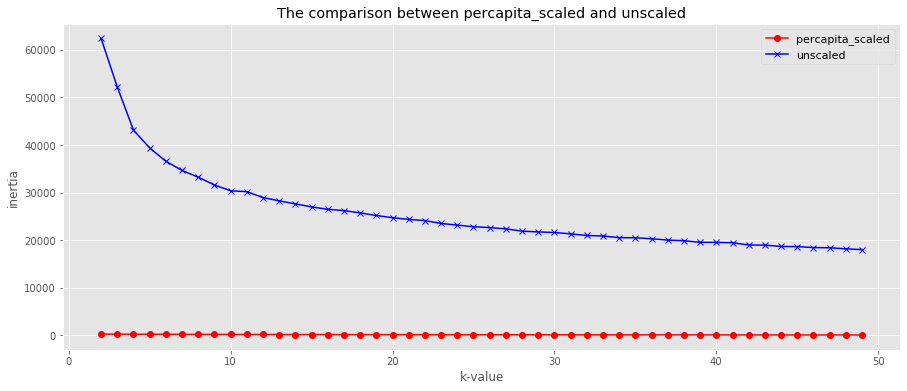

In [43]:
# then we plot the above evaluation of the above two Kmeans clustering in one single picture
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(["ggplot"])
fig=plt.figure(figsize=(15,6))
ax=fig.add_subplot(1,1,1)
ax.plot(K, Sum_of_squared_distances_scaled, 'ro-', label='percapita_scaled')
ax.plot(K, Sum_of_squared_distances, 'bx-', label='unscaled')
ax.set(title="The comparison between percapita_scaled and unscaled",
       ylabel="inertia",
       xlabel="k-value")
ax.legend(fontsize=11)

plt.show()

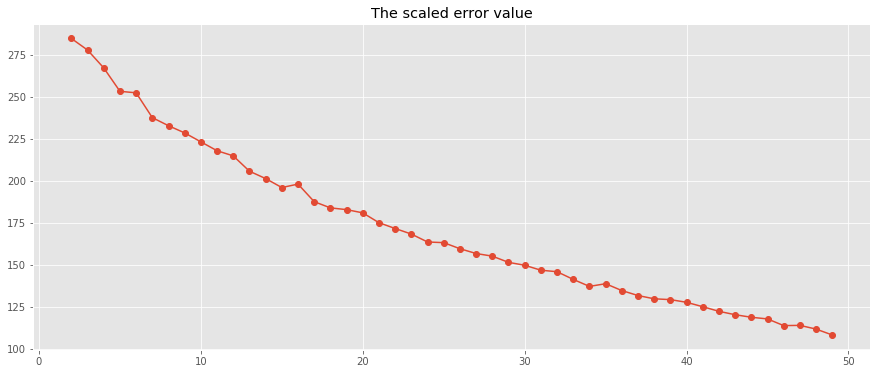

In [44]:
fig=plt.figure(figsize=(15,6))
ax=fig.add_subplot(1,1,1)
ax.plot(K, Sum_of_squared_distances_scaled,"o-")
ax.set(title="The scaled error value")
plt.show()

In [45]:
# for unscaled X set, we will use cluster number equals 5
k_means = KMeans(init = "k-means++", n_clusters = 5)
k_means.fit(X)
k_means_labels = k_means.labels_
df_explore_group["nb_group"]=k_means_labels
df_explore_group.head()

,nb_code,area,population,lat,lon,ATM,Airport,Alley,Amphitheater,Aquarium,...,University,Veterinarian,Vineyard,Wash,Waterfront,Winery,Workshop,Zone,Zoo,nb_group
0,11226,"Brooklyn, New York",106154,40.646430,-73.956866,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,11373,"Elmhurst, New York",105723,40.737347,-73.878716,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,10021,"New York, New York",102078,40.769742,-73.961653,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11368,"Corona, New York",98841,40.749407,-73.852780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,11385,"Ridgewood, New York",97524,40.700671,-73.889433,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Now we can plot it for New York.

In [46]:
df_explore_group_ny=df_explore_group[df_explore_group.lat<42]
df_explore_group_tor=df_explore_group[df_explore_group.lat>42]
ls_color=["#edfafd",
      #   "#aed9da",
         "#3ddad7",
      #   "#2a93d5",
         "#135589",
      #   "#f5aB99",
         "#feb47b",
      #   "#ff7e5f",
          "#765285",
      #    "#351c4d"
         ]
ls_nb_group=range(0,5)
df_color_10=pd.DataFrame()
df_color_10["nb"]=ls_nb_group
df_color_10["color"]=ls_color
df_explore_group_ny=pd.merge(df_explore_group_ny,df_color_10,how="left",left_on="nb_group",right_on="nb")
df_explore_group_tor=pd.merge(df_explore_group_tor,df_color_10,how="left",left_on="nb_group",right_on="nb")

In [48]:
import folium
world_map=folium.Map()
ny_map = folium.Map(location=[40.785091, -73.878985], tiles='Stamen Toner', zoom_start=12)


for lat, lng, label, mark_color in zip(df_explore_group_ny.lat,
                                  df_explore_group_ny.lon,
                                  df_explore_group_ny.nb_group,
                                 df_explore_group_ny.color):
    folium.CircleMarker(
        [lat, lng],
        radius=7,# define how big you want the circle markers to be
        popup=label,
        color=mark_color,
        fill=True,
        fill_color=mark_color,
        fill_opacity=0.8
    ).add_to(ny_map)
    
ny_map

Now we plot it for Toronto.

In [49]:
import folium
tor_map = folium.Map(location=[43.691070, -79.347015], tiles='Stamen Toner', zoom_start=12)


for lat, lng, label, mark_color in zip(df_explore_group_tor.lat,
                                  df_explore_group_tor.lon,
                                  df_explore_group_tor.nb_group,
                                 df_explore_group_tor.color):
    folium.CircleMarker(
        [lat, lng],
        radius=7,# define how big you want the circle markers to be
        popup=label,
        color=mark_color,
        fill=True,
        fill_color=mark_color,
        fill_opacity=0.8
    ).add_to(tor_map)

tor_map

Also we do the clustering for scaled dataframe.

In [50]:
# for the scaled x feature dataset, we use cluster number equals 5
k_means_scaled = KMeans(n_clusters = 5)
k_means_scaled.fit(feature_scaled)
df_explore_group_scaled["nb_group_scaled"]=k_means_scaled.labels_
df_explore_group["nb_group_scaled"]=k_means_scaled.labels_
df_explore_group_scaled.head()

,nb_code,area,population,lat,lon,ATM,Airport,Alley,Amphitheater,Aquarium,...,University,Veterinarian,Vineyard,Wash,Waterfront,Winery,Workshop,Zone,Zoo,nb_group_scaled
0,11226,"Brooklyn, New York",106154,40.646430,-73.956866,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0
1,11373,"Elmhurst, New York",105723,40.737347,-73.878716,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0
2,10021,"New York, New York",102078,40.769742,-73.961653,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0
3,11368,"Corona, New York",98841,40.749407,-73.852780,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0
4,11385,"Ridgewood, New York",97524,40.700671,-73.889433,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0


In [51]:
# we will try to find the most important venues and use them as a feature to do linear regression
#df_explore_group_sub=df_explore_group[df_explore_group.nb_group_scaled==1].iloc[:,5:197]
ls_explore_group_top20=df_explore_group.iloc[:,5:197].sum(axis=0).sort_values(ascending=False).head(20).index
ls_explore_group_top20

Index(['Restaurant', 'Shop', 'Store', 'Place', 'Bar', 'Park', 'Pharmacy',
       'Joint', 'Bakery', 'Bodega', 'Bank', 'Café', 'Gym', 'Station', 'Center',
       'Supermarket', 'Diner', 'Studio', 'Theater', 'Hotel'],
      dtype='object')

In [53]:
# for scaled X set, we can see there is no real difference with the k number
# --> if we devide the number of venues by the population
# --> we can to the conclusion that they all have a similar "venue per person" number
# --> the venues number have a correlation with the population in almost every area

from sklearn.linear_model import LinearRegression
ls_lr_pop=list()
ls_lr_pop_score=list()
for nb_group in range(0,5):
    lm=LinearRegression()
    ls_explore_group_top20=df_explore_group[df_explore_group.nb_group==nb_group].iloc[:,5:197].sum(axis=0).sort_values(ascending=False).head(20).index
    X_explore = df_explore_group[df_explore_group.nb_group==nb_group][ls_explore_group_top20]
    Y_explore = df_explore_group[df_explore_group.nb_group==nb_group]["population"]
    lm.fit(X_explore, Y_explore)
    #Yhat=lm.predict(X)

    #lm.intercept_
    #lm.coef_
    ls_lr_pop_score.append(lm.score(X_explore,Y_explore))
    df_lm_result=pd.DataFrame()
    df_lm_result["venue"]=ls_explore_group_top20
    df_lm_result["influence"]=lm.coef_
    ls_lr_pop.append(df_lm_result)

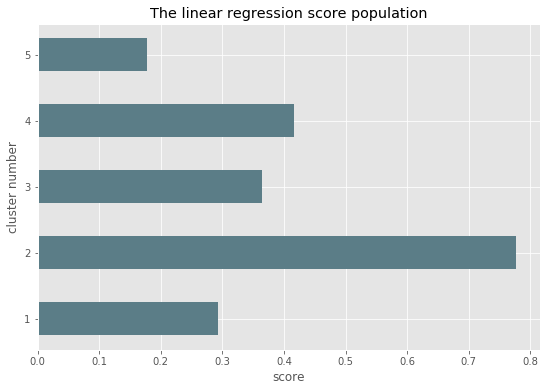

In [54]:
i_number=list(range(1,6))
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(1,1,1)
ax.barh(i_number,ls_lr_pop_score,height=0.5,color="#5B7D87")
ax.set(title="The linear regression score population",
       ylabel="cluster number",
       xlabel="score")
plt.show()

## The correlattion of the venue numbers to the population:

In [55]:
pd.merge(ls_lr_pop[2],ls_lr_pop[4],how="inner",on="venue")

,venue,influence_x,influence_y
0,Restaurant,40.125798,757.007791
1,Shop,-677.097306,-309.230374
2,Store,487.363208,-1199.615283
3,Bar,621.417381,-995.062770
4,Place,-110.369877,1548.868753
5,Bakery,3020.045529,1562.848678
6,Park,39.133500,2561.891787
7,Joint,1514.784086,2311.169081
8,Gym,-1670.532415,3449.835727
9,Pharmacy,-8973.381632,2800.511232


## Now we need to check what happens to the income

This follow block imports and preprocess the income information.

In [56]:
# this may take several minutes to run
# get the canada income via Canada Census Profile
# here you will see the link:
# https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page_Download-Telecharger.cfm?Lang=E&Tab=1&Geo1=FSA&Code1=M1B&Geo2=PR&Code2=01&SearchText=M1B&SearchType=Begins&SearchPR=01&B1=All&TABID=2&type=0
# here i downloaded it and saved over locally
df_can_income_raw=pd.read_csv("98-401-X2016046_English_CSV_data.csv")
df_can_post=pd.read_csv("post_df_can.csv",index_col=0)

df_can_post_income=pd.DataFrame()
ls_can_post=df_can_post.index.tolist()
ls_can_post_income=list()

for i in ls_can_post:
    df_can_income_raw_i=df_can_income_raw[df_can_income_raw["GEO_CODE (POR)"]==i]
    df_can_income_i=df_can_income_raw_i[df_can_income_raw_i["DIM: Profile of Forward Sortation Areas (2247)"]=="Median total income in 2015 among recipients ($)"]
    if len(df_can_income_i)==0: # there are cases where you don't have the value collected
        ls_can_post_income.append("x")
    else:
        ls_can_post_income.append(df_can_income_i.iloc[0,12])
    
df_can_post_income["post_code"]=ls_can_post
df_can_post_income["income"]=ls_can_post_income
df_can_post_income=df_can_post_income[df_can_post_income["income"]!="x"]
df_can_post_income["income"]=df_can_post_income["income"].astype("int")*0.8

The following block will run the new york dataset.

In [57]:
# get the new york income via "income by zip code"
# some preprocessing step
df_ny_nb=pd.read_csv("df_ny_nb.csv",index_col=0)
df_ny_nb["zip_group"]=df_ny_nb["zip_group"].astype("int")
df_ny_nb=df_ny_nb[df_ny_nb["zip_group"]<120]
df_ny_nb=df_ny_nb[df_ny_nb["zip_group"]>=100]
df_ny_nb=df_ny_nb[df_ny_nb["population"]>100]

df_ny_post_income=pd.read_csv("df_ny_post_income.csv",index_col=0)
df_post_income=pd.concat([df_ny_post_income,df_can_post_income],axis=0)

We put the above two dataframe together into one.

In [58]:
# we need to merge the explore group from above for clustering together with the income data
# first we need to set both the nb_code values to type integer
df_explore_group["nb_code"]=df_explore_group["nb_code"].astype("str")
df_post_income["post_code"]=df_post_income["post_code"].astype("str")
df_all=pd.merge(df_explore_group,df_post_income,how="inner",left_on="nb_code",right_on="post_code")
df_all

,nb_code,area,population,lat,lon,ATM,Airport,Alley,Amphitheater,Aquarium,...,Wash,Waterfront,Winery,Workshop,Zone,Zoo,nb_group,nb_group_scaled,post_code,income
0,11226,"Brooklyn, New York",106154,40.646430,-73.956866,0,0,0,0,0,...,0,0,0,0,0,0,3,0,11226,24798.0
1,11373,"Elmhurst, New York",105723,40.737347,-73.878716,0,0,0,0,0,...,0,0,0,0,0,0,2,0,11373,22249.0
2,10021,"New York, New York",102078,40.769742,-73.961653,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10021,125769.0
3,11368,"Corona, New York",98841,40.749407,-73.852780,0,0,0,0,0,...,0,0,0,0,0,1,3,0,11368,16826.0
4,11385,"Ridgewood, New York",97524,40.700671,-73.889433,0,0,0,0,0,...,0,0,0,0,0,0,3,0,11385,27568.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,11430,"Jamaica, New York",229,40.650916,-73.788526,0,1,0,0,0,...,0,0,0,0,0,0,3,2,11430,7330.0
562,11947,"Jamesport, New York",218,40.947855,-72.575934,0,0,0,0,0,...,0,0,2,0,0,0,4,0,11947,60464.0
563,11770,"Ocean Beach, New York",190,40.644757,-73.160803,0,0,0,0,0,...,0,0,0,0,0,0,4,0,11770,50122.0
564,10519,"Croton Falls, New York",156,41.342055,-73.661095,0,0,0,0,0,...,0,0,0,0,0,0,4,0,10519,97884.0


In [60]:
from sklearn.linear_model import LinearRegression

lr_result=[]
i_number=[]

for i in range(0,5):
    i_number.append(i)
    df_all_sub=df_all[df_all.nb_group==i].iloc[:,5:197]
    ls_all_top10=df_all_sub.sum(axis=0).sort_values(ascending=False).head(15).index
    lr_i=LinearRegression()
    X_i=df_all_sub[ls_all_top10]
    Y_i=df_all[df_all.nb_group==i]["income"]
    lr_i.fit(X_i,Y_i)
    lr_result.append(lr_i.score(X_i,Y_i))

df_lr=pd.DataFrame()
df_lr["result"]=lr_result
df_lr["number"]=i_number

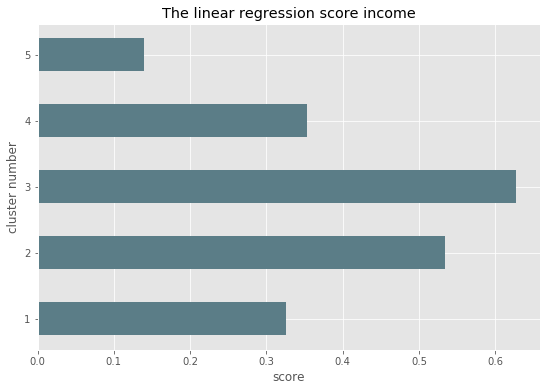

In [61]:
# As usual we will plot the result

i_number=list(range(1,6))
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(1,1,1)
ax.barh(i_number,lr_result,height=0.5,color="#5B7D87")
ax.set(title="The linear regression score income",
       ylabel="cluster number",
       xlabel="score")
plt.show()

Define the following function to get multiple entries at the same time.

In [62]:

def generate_dataframe(a,b):
    result=[]
    for i in range(a,b):
        df_lr_i=pd.DataFrame()
        lr_i=LinearRegression()
        df_all_i=df_all[df_all.nb_group==i].iloc[:,5:197]
        ls_all_top=df_all_i.sum(axis=0).sort_values(ascending=False).head(15).index
        X_i=df_all_i[ls_all_top]
        Y_i=df_all[df_all.nb_group==i]["income"]
        lr_i.fit(X_i,Y_i)
        df_lr_i["venue"]=ls_all_top
        infl_col="influence_{}".format(i)
        df_lr_i[infl_col]=lr_i.coef_
        result.append(df_lr_i)
    return result
#pd.merge(result[],result[2],how="inner",on="venue")

We choose to see the cluster 2 and 3, since they have a higher score.

In [64]:
result=generate_dataframe(2,4)
result23=pd.merge(result[0],result[1],how="inner",on="venue")
result23

,venue,influence_2,influence_3
0,Restaurant,-41.780045,331.115547
1,Shop,459.214027,618.283241
2,Store,202.055900,-1140.450613
3,Bar,594.654430,-789.371396
4,Place,-1548.714615,-1741.058567
5,Bakery,-1055.093983,-2576.702582
6,Café,-2123.490190,-987.225599
7,Park,5655.962695,-625.392780
8,Joint,4736.168726,-2755.504857
9,Gym,2933.493727,6568.742229


# BACKUP

In [2]:
df_explore_venue=pd.read_csv("df_explore_venue.csv",index_col=0)
df_explore_venue["latdis"]=(df_explore_venue["lat"]-df_explore_venue["Venue Latitude"])
df_explore_venue["lngdis"]=df_explore_venue["lng"]-df_explore_venue["Venue Longitude"]
df_explore_venue["dis"]=((df_explore_venue["latdis"])**2+(df_explore_venue["lngdis"])**2)**0.5

# we found out that there are duplicate venues in the dataframe
# with this block the duplicates will be droped
# only the venue with the shortest distance to the center of neighborhood will be kept
df_explore_venue_wo=df_explore_venue.groupby(by="Venue_ID")["dis"].nsmallest(1)
df_explore_venue=df_explore_venue.iloc[df_explore_venue_wo.index.get_level_values(1)]
df_explore_venue=df_explore_venue.drop(columns=["latdis","lngdis","dis"])
df_explore_venue=df_explore_venue.sort_index().reset_index().drop(columns=["index"])


TypeError: to_csv() got an unexpected keyword argument 'index_col'

In [4]:
# !!!no need to run this block anymore, once df_ny_nb.csv is generated!!!
# there is a problem with the dataset provided by the course --> cannot really use the neighborhood information to find the related population
# now i refer to another website and find a new dataset
df_ny_nb=pd.DataFrame()
for i in range(1,17):
    url_raw_ny_nb_i="http://zipatlas.com/us/ny/zip-code-comparison/population-density.{}.htm".format(i)
    raw_ny_nb_i=pd.read_html(url_raw_ny_nb_i)
    df_ny_nb_i=raw_ny_nb_i[10].iloc[1:,:]
    df_ny_nb=pd.concat([df_ny_nb,df_ny_nb_i],axis=0)
# then change the colnames to the natural language
df_ny_nb.rename(columns={0:"rawindex",
                         1:"zip",
                         2:"ll",
                         3:"district",
                         4:"population",
                         5:"popu_permilesquare",
                         6:"rank"},
                inplace = True)
# take only the first 3 characters of the zip
df_ny_nb["zip_group"]=df_ny_nb["zip"].str[:3]
df_ny_nb["population"] = df_ny_nb["population"].astype(int)
df_ny_nb.to_csv("df_ny_nb.csv")

In [96]:
pd.read_csv("df_ny_nb.csv",index_col=0)

,rawindex,zip,ll,district,population,popu_permilesquare,rank,zip_group
1,1.0,10162,"40.769298, -73.949942","New York, New York",1726,151834.77,#1,101
2,2.0,10028,"40.776865, -73.954721","New York, New York",44987,126067.69,#2,100
3,3.0,10128,"40.781656, -73.950281","New York, New York",59856,122356.52,#3,101
4,4.0,10031,"40.825857, -73.949451","New York, New York",60221,101100.03,#5,100
5,5.0,10009,"40.726622, -73.978955","New York, New York",58595,100687.04,#6,100
...,...,...,...,...,...,...,...,...
95,1595.0,12847,"44.000125, -74.563880","Long Lake, New York",723,1.77,"#30,756",128
96,1596.0,12139,"43.500184, -74.579588","Piseco, New York",272,1.48,"#30,933",121
97,1597.0,12855,"44.027010, -73.758053","North Hudson, New York",263,1.43,"#30,957",128
98,1598.0,13353,"43.447326, -74.694618","Hoffmeister, New York",151,0.90,"#31,270",133


In [10]:
# !!!no need to run this block any more
# get the population of cannada based on the geographic code
url_can_pop="https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV"
df_can_pop=pd.read_csv(url_can_pop,encoding = "ISO-8859-1")
df_can_pop=df_can_pop[:-6]
df_can_pop=df_can_pop[["Geographic code","Population, 2016"]]
df_can_pop
# merge the population to the postal code based on the geographic code
df_can_post=df_can_post.merge(df_can_pop,how="left",left_on="Postcode",right_on="Geographic code")
# check whether there is na value
df_can_post[df_can_post["Population, 2016"].isna()]
# apparently this is just a postcode specific for the canada post gateway
# so we can drop this line
df_can_post=df_can_post[~df_can_post["Population, 2016"].isna()]
df_can_post.to_csv("df_can_post.csv")

In [97]:
pd.read_csv("df_can_post.csv",index_col=0)

,Borough,Neighborhood,Latitude,Longitude,Geographic code,"Population, 2016"
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353,M1B,66108.0
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,M1C,35626.0
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,M1E,46943.0
3,Scarborough,Woburn,43.770992,-79.216917,M1G,29690.0
4,Scarborough,Cedarbrae,43.773136,-79.239476,M1H,24383.0
...,...,...,...,...,...,...
98,York,Weston,43.706876,-79.518188,M9N,25074.0
99,Etobicoke,Westmount,43.696319,-79.532242,M9P,20874.0
100,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724,M9R,33743.0
101,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,M9V,55959.0


In [45]:
list_needed=["nb_code","area","population","lat","lon"]
df_ny_nb=df_ny_nb[list_needed]
df_can_post=df_can_post[list_needed]
df_nb=pd.concat([df_ny_nb,df_can_post],axis=0)
df_nb["population"]=df_nb["population"].astype("int")
df_nb.to_csv("df_nb.csv")

In [16]:
df_nb=df_nb[df_nb.population>100]
df_nb=df_nb.sort_values("population",ascending=False).reset_index().drop(columns=["index"])
df_nb.to_csv("df_nb.csv")

In [18]:
# get the venue searching information based on the latitude/longtitude
import json, requests

VERSION="20180323"
RADIUS=1500
LIMIT=300

def getNearbyVenues(latitudes, longitudes, nb_codes):
    
    venues_list=[]
    for lat, lng, nb_code in zip(latitudes, longitudes, nb_codes):
        url_ex = 'https://api.foursquare.com/v2/venues/explore'

        params_ex = dict(
            client_id=CLIENT_ID2,
            client_secret=CLIENT_SECRET2,
            v=VERSION,
            ll=','.join([str(lat),str(lng)]),
            radius=RADIUS,
            limit=LIMIT)
        req_ex = requests.get(url=url_ex, params=params_ex)
        data_ex = json.loads(req_ex.text)
        results = data_ex["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            nb_code,
            lat, 
            lng, 
            result['venue']['name'],
            result['venue']["id"],
            result['venue']['location']['lat'], 
            result['venue']['location']['lng'],  
            result['venue']['categories'][0]['name']) for result in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        "nb_code",
        'lat',
        'lng',
        "Venue",
        "Venue_ID",
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']
    
    return(nearby_venues)

In [20]:
# this may take several minutes to run
df_explore_venue=getNearbyVenues(df_nb["lat"],df_nb["lon"],df_nb["nb_code"])
df_explore_venue.to_csv("df_explore_venue.csv")

In [71]:
df_explore_venue_wo=pd.DataFrame()
ls_explore_venue_nb_code=list()
ls_explore_venue_nb_lat=list()
ls_explore_venue_nb_lng=list()
ls_explore_venue_venue=list()
ls_explore_venue_id=list()
ls_explore_venue_cat=list()

for venue_id in set(df_explore_venue.Venue_ID.tolist()):
    df_explore_venue_sub=df_explore_venue[df_explore_venue.Venue_ID==venue_id].reset_index()
    if df_explore_venue_sub.shape[0]==1:
        df_explore_venue_wo=pd.concat([df_explore_venue_wo,df_explore_venue_sub],axis=0)
    else:
        df_explore_venue_sub_wo=df_explore_venue_sub.iloc[df_explore_venue_sub["dis"].idxmin]
        df_explore_venue_wo=pd.concat([df_explore_venue_wo,df_explore_venue_sub_wo],axis=0)

C:\Users\WENCAI\AppData\Local\conda\conda\envs\IBM_Certified\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


KeyboardInterrupt: 

In [87]:
# the plan was to get the venue rating, but since we are not allowed to call more than 50 times per day with normal account
# --> it will take 200 days to collect
# --> !!!I GIVE UP!!!
# still keeping the code here for the future possible use
def getVenueRating(venue_id_list):
    venues_rating=pd.DataFrame()
    for venue_id in venue_id_list:
        url_ve='https://api.foursquare.com/v2/venues/{}'.format(venue_id)
        params_ve = dict(
            client_id=CLIENT_ID2, # pay attention to use other credentials if reached the quota
            client_secret=CLIENT_SECRET2, # pay attention to use other credential
            v=VERSION)
        req_ve = requests.get(url=url_ve, params=params_ve)
        data_ve = json.loads(req_ve.text)
        if "rating" in data_ve["response"]["venue"]:
            rating_value=data_ve["response"]["venue"]["rating"]
        else:
            rating_value=float('naN')
        result_d={"venue_id":[data_ve["response"]["venue"]["id"]],
                  "venue_name":[data_ve["response"]["venue"]["name"]],
                  "venue_rating":[rating_value],
                  "venue_category":[data_ve["response"]["venue"]["categories"][0]["name"]]}
        result=pd.DataFrame(result_d)
        venues_rating=venues_rating.append(result)
    return venues_rating

In [17]:
# !!! no need to run this block, doesnt really bring much benefit
import nltk 
from nltk.corpus import wordnet
# build a function to return the synonyms
def getsyn(word):
    synonyms = [] 
    # loop through the possible results
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name())
    synonyms=list(set(synonyms))
    return synonyms

In [57]:
# !!! no need to run this blok, doesnt really bring much benefit
df_explore_venues_cat_syn_str=[]
for word in df_explore_venues_cat_simple_str:
    word_syn=getsyn(word)
    if len(word_syn)==0:
        df_explore_venues_cat_syn_str.append(word)
    else:
        df_explore_venues_cat_syn_str.append(word_syn[0])
    

In [ ]:
# this is how you get the new york salary data
df_ny_post_income=pd.DataFrame()
ls_ny_post=df_ny_nb.zip.tolist()
ls_ny_income_raw=[]
# this may take several minutes to run
for i in ls_ny_post:
    url_raw_i="https://www.incomebyzipcode.com/newyork/{}".format(i)
    html_raw_i=pd.read_html(url_raw_i)
    ls_ny_income_raw.append(html_raw_i[2].iloc[0,0])

ls_ny_income=[]
for i in range(0,len(ls_ny_income_raw)):
    i_dollar=ls_ny_income_raw[i][1:]
    ls_ny_income.append(i_dollar.split(",")[0]+i_dollar.split(",")[1])    

df_ny_post_income["post_code"]=ls_ny_post
df_ny_post_income["income"]=ls_ny_income
df_ny_post_income.to_csv("df_ny_post_income.csv")

In [5]:
# some preprocessing steps
#df_ny_nb_lat=df_ny_nb['ll'].str.split(",",n=1,expand=True) # split the ll information into latitude and longitude
#df_ny_nb["lat"]=df_ny_nb_lat[0] # put the latitude information to the latitude column
#df_ny_nb['lon']=df_ny_nb_lat[1] # put the longitude information to the longitude column
#df_ny_nb["lat"]=df_ny_nb["lat"].astype("float") # change the type to float
#df_ny_nb["lon"]=df_ny_nb["lon"].astype("float") # change the type to float

#df_ny_nb.head()